## Preprocès: ##

- Eliminar els digits del text
- Convertir tot el text a minúscula
- Substitueix els espais en blanc continus per un de sol
- Concatena totes les frases amb un espai doble al mig 


In [2]:
import re 
from nltk.collocations import TrigramCollocationFinder, ngrams
from collections import Counter, defaultdict
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import glob

S’han creat dos funcions, una per fer les modificacions pertients a cada text i una per carregar els textos de cada idioma i preprocessar els textos utiltzant la funció anterior. A continuació s’han utilitzat bucles per dur a terme la carrega del textos per cada idioma. 

Totes aquestes dades processades s’ha emmagatzemat en un diccionari per al train, on cada clau es l'idioma i el valor és el text. Pel test hem fet servir un una llista per X_test, on es guarden les frases, i un altre per y_test on es guarda l'idioma de cada frase per després comprobar. Pel train 

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\d+', '', text) 
    text = text.lower()  
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\n', '  ', text)  
    return text

def load_and_preprocess_data(data_path):
    with open(data_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return preprocess_text(text)


languages = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa']
path = 'C:/Users/Paess/Documents/Uni/Segon/PLH/langId'
train_split = {}


for idiom in languages:
    file_path = os.path.join(path, f'{idiom}_trn.txt')
    text = load_and_preprocess_data(file_path)
    train_split[idiom] = text


X_test = []
y_test = []

for idiom in languages:
    file_path = os.path.join(path, f'{idiom}_tst.txt')

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines() 
    
    for line in lines:
        sentence = preprocess_text(line.strip()) 
        if sentence:  
            X_test.append(sentence)
            y_test.append(idiom)





S’han creat dos funcions, una per generar els trigrams i una per eliminar els trigrames amb frequencia menor que 5. Dinalment, s'ha utilitzat un bucle per dur a terme aquestes dues funciones i aixi quedarnos amb els trigrames més frequents de cada idioma. 

In [ ]:
def generate_trigrams(text):
    
    lletres = list(text) 
    trigrams = [''.join(trigram) for trigram in ngrams(lletres, 3) if len(trigram) == 3]
    return trigrams

def frequent_trigrams(trigrams):
    trigram_counts = Counter(trigrams)
    frequent_trigrams_set = {trigram for trigram, count in trigram_counts.items() if count >= 5}
    return [trigram for trigram in trigrams if trigram in frequent_trigrams_set]



for idiom in train_split: 
    train_split[idiom] = frequent_trigrams(generate_trigrams(train_split[idiom]))
    


Aquest fragment de codi calcula i emmagatzema paràmetres clau per a cada idioma al diccionari parametres_LID, recorrent els trigrames del conjunt d'entrenament train_split i calculant dos valors essencials: NT, que representa el nombre total de trigrames en el conjunt d'entrenament d'un idioma específic, i B, que correspon a l'espai total de possibles trigrams 27 caràcters incloent l'espai

In [ ]:
parametres_LID = {}
for idiom, trigrams in train_split.items():
    NT = len(trigrams)
    B = 27**3
    parametres_LID[idiom] = {'NT': NT, 'B': B}


$$ LID = \frac{C_t(e_j) + \lambda}{N_t + \lambda B} $$

on:  
- \( C_t(e_j) \) és el recompte del trigram \( e_j \) en la llengua \( t \).  
- \( \lambda \) és el paràmetre de suavització.  
- \( N_t \) és el nombre total de trigramas en la llengua \( t \).  
- \( B \) és el nombre total de trigramas possibles.  

Aquesta fórmula permet calcular la probabilitat estimada d'un trigram en una llengua donada.


In [ ]:
def LID(count_trigram, NT, B, lam=0.5):
    result= np.log((count_trigram + lam) / (NT + lam * B))
    return result

Primer, crea un diccionari trigram_counts, on per a cada trigram present en les dades d'entrenament train, s'assigna un subdiccionari que inicialitza el recompte d'aquell trigram per a cada llengua. Després, recorre els trigramas de cada llengua i actualitza els seus recomptes dins de trigram_counts. A continuació, es construeix trigram_LID, que conté les probabilitats calculades per a cada trigram en cada llengua mitjançant la funció LID(), que utilitza els paràmetres NT (nombre total de trigramas en cada llengua) i B (nombre total de trigramas possibles) per estimar la probabilitat de cada trigram aplicant suavització amb lam. Finalment, la funció retorna trigram_LID, un diccionari que representa la distribució de trigramas i les seves probabilitats associades per a cada llengua, permetent així utilitzar aquest model per predir la llengua de noves frases en fases posteriors.

In [ ]:
def entrenament_model(train, lam=0.5):
    trigram_counts = {trigram: {lang: 0 for lang in languages} for lang in languages for trigram in train.get(lang, [])}
    
    for lang, lang_trigrams in train.items():
        for trigram in lang_trigrams:
            trigram_counts[trigram][lang] += 1
    
    trigram_LID = {}
    for trigram, lang_counts in trigram_counts.items():
        trigram_LID[trigram] = {lang: LID(count, parametres_LID[lang]['NT'], parametres_LID[lang]['B'], lam) for lang, count in lang_counts.items()}
    
    return trigram_LID

Aquesta funció s'encarrega de predir la llengua d'un text donat mitjançant l'anàlisi dels seus trigramas i la comparació amb un model entrenat. Primer, preprocesa el text amb preprocess_text i genera els trigramas corresponents amb generate_trigrams. A continuació, inicialitza LID_idiom, un diccionari que conté la probabilitat acumulada per a cada llengua, inicialitzada a zero. Per cada trigrama generat, comprova si existeix en trigram_LID; si és així, recupera les probabilitats associades a cada llengua, i si no, assigna una probabilitat suposada aplicant la funció LID() amb un recompte inicial de zero i els paràmetres de suavització. Després, acumula aquests valors en LID_idiom, reflectint la probabilitat total del text per a cada llengua. Posteriorment, aplica una normalització Min-Max per reescalar els valors entre 0 i 100 per fer-los comparables. Finalment, determina la llengua amb la probabilitat més alta i retorna un diccionari amb les probabilitats normalitzades de cada llengua i la llengua més probable segons el model.

In [ ]:

def predict(text, trigram_LID, lam=0.5):
    text_preprocessat = preprocess_text(text)  
    trigrams = generate_trigrams(text_preprocessat) 
    
    LID_idiom = {lang: 0 for lang in parametres_LID}  
    
    for trigram in trigrams:
        if trigram in trigram_LID:
            LID_per_lang_trigram = trigram_LID[trigram]  
        else:
            LID_per_lang_trigram = {lang: LID(0, parametres_LID[lang]['NT'], parametres_LID[lang]['B'], lam) for idiom in parametres_LID}
        for lang, LID_trigram in LID_per_lang_trigram.items():
            LID_idiom[lang] += LID_trigram 

    min_val = min(LID_idiom.values())
    max_val = max(LID_idiom.values())
    
    if max_val == min_val: 
        probabilities = {lang: float(100 / len(LID_idiom)) for lang in LID_idiom}
    else:
        probabilities = {lang: float(((score - min_val) / (max_val - min_val)) * 100) for lang, score in LID_idiom.items()}  

    max_language = max(probabilities, key=probabilities.get)  

    return probabilities, max_language

Aquesta línia de codi crida la funció entrenament_model, que entrena un model d'identificació de llengua basat en trigramas a partir de les dades de train_split. La funció entrenament_model calcula la freqüència dels trigramas en cada llengua i aplica la funció LID() per estimar la probabilitat de cada trigrama mitjançant una suavització amb el paràmetre λ = 0.5. El resultat d'aquest entrenament es guarda a trigram_LID, un diccionari que conté, per a cada trigrama, un subdiccionari amb les probabilitats de pertànyer a cadascuna de les llengües considerades.

A continuació, es fa una prova amb una frase senzilla en castellà i es pot observar que retorna un 100% de probabilitats de que sigui en castellà, cosa que suggereix que el model funciona correctament. 

In [14]:
trigram_LID = entrenament_model(train_split, 0.5)


In [15]:
text = "Hola, com estás?"

print(predict(text, trigram_LID, 0.5))

({'deu': 0.0, 'eng': 35.04509486508014, 'fra': 35.185960429637674, 'ita': 44.41237071387217, 'nld': 5.242111175603981, 'spa': 100.0}, 'spa')


In [ ]:
def test(X_test, y_test, trigram_LID, lam=0.5):
    y_pred = []
    for sentence, actual_lang in zip(X_test, y_test):
        _, lang = predict(sentence, trigram_LID, lam)
        y_pred.append(lang)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, f1, conf_matrix

Accuracy: 0.9989
Precision: [0.9989992  0.99730297 0.9993997  0.99919936 0.9989987  0.9993    ]
F1-score: 0.9989


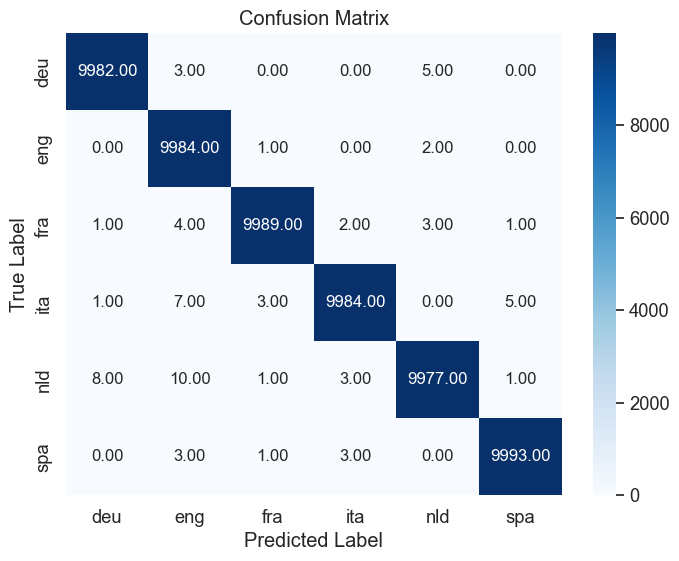

In [ ]:
accuracy, precision, f1, conf_matrix = test(X_test, y_test, trigram_LID, 0.5)

# Mostrar métricas de evaluación
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'F1-score: {f1:.4f}')

classes = np.unique(y_test)


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt=".2f", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
